In [58]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%pdb on
import sys  
import numpy as np
import os
from scipy import *
from scipy.linalg import solve
import copy
import matplotlib.pyplot as plt
import matplotlib as mt
from datetime import datetime
import time
from trajectoriesOfTaxis import *
from scipy.interpolate import UnivariateSpline
import pandas as pd


### Here I will iterate through all the data files in the data directory and create a taxi object from each

The data is filtered for bad points in the creation of a taxi object.

Acceleration and velocity quantities are also generated

It is done so in the following way:

    given points p1, p2, and p3:
		
        deltaT_12 = t2-t1
        deltaT_23 = t3-t2
		deltaX_12 = x2-x1
		velocityX_12 =  deltaX_12/deltaT_12; note that this would be 
											  the velocity at t_2
		deltaVx_23 = veolcityX_23-velocityX_12
		accelerationX_23 = deltaVx_23/deltaT_23^{2}
		
		Bad Data points are defined in the following way:
			
			1) t2 = t1 (identical time stamps)
			2) t2 < t1 (decreasing time)
			3) velocity is greater than some predefined velocity;
			this condition would correspond to points that moved 
			and erroneous distance in s short amount of time.
			4) acceleration is greater than some predefined value.
			This is a bad point for analogous reasons to 3)

			
		The "bad" data point along with the data point right before
		are written to a file named badPointsForTaxi{taxiID}.txt.
		The reason the point right before is also written is because
		the bad point was determined to be bad only context to the 
		point that came right before. Refer to the criteria for 
		bad points right above.

    

In [2]:
path = "./taxiData/"
taxis = []
for i in os.listdir(path):
    taxis.append(Taxi.fromFile(path+i))

 ### Time interval and distance interval histogram of all taxi objects can be created with the deltaX, deltaY and deltaT quantities.
 
 note that deltaT is divided by 60 to convert seconds to minutes 
 
 note that the distance histogram is for the following quantity $ \sqrt{deltaX^{2}+deltaY^{2}} $
 
 note histograms normalized such that integral is 1

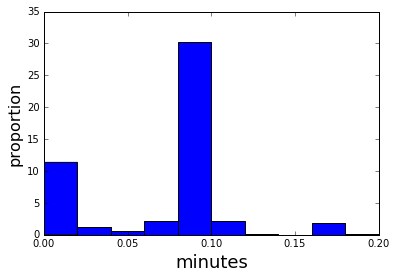

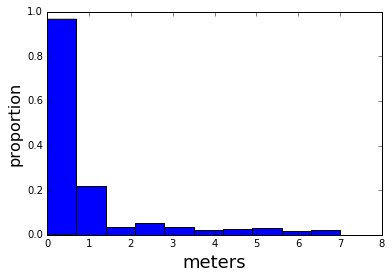

In [3]:
createHistograms(taxis)

### In the following taxi objects with smoothed trajectories will be created.
The smoothing method takes in a taxi object, a desired time lapse between consecutive

points in units of seconds, and an integer 1, 2, or 3 representing which algorithm  to run. 

The smaller the desired time lapse the finer the plot but the 

runtime will be longer.

**Smoothing with algorithm 1 done in the following manner:**
    
    The fundamental assumptions are:
		1) The data inputed is free of error such that the positions and time 
		data are in fact the true values
		2)The acceleration between any two points is linear in t such that
$$ 
\begin{align}
a(t) &= a0 + c\cdot t\\
v(t) &= v0 + a0\cdot t + \frac{c}{2}\cdot t^{2}\\
x(t) &= x0 + v0\cdot t + \frac{a0}{2}\cdot t^2 + \frac{c}{6}\cdot t^3
\end{align}
$$

	Thus to smooth the trajectory we will fit every 3 points to a cubic function in form of x(t).
	As an example consider points p1, p2, p3, and p4:
		iteration 1: fit to p1, p2 and p3; generate more points between p1 and p2 with fit
		iteration 2: fit to p2, p3 and p4; generate more points between p2 and p3 with fit
        
    The Number of points generated is dictated by the second input in the smoothing function which is 
    the desiredDeltaT or time interval between consecutive points:
        
        smoothTrajectory(taxiObject,desiredDeltaT)
		
		continue in this fashion...
        
The motivation for applying the fit to only two of the points and not all three is influenced by the 

mechanics of driving. The velocity of the vehicle is at any moment controlled by the driver not by natural 

phenomenon that may adhere to a nice function. Thus at face value it seems logical to re-fit

at every new point

In [4]:
taxi = taxis[0]
smoothTaxi = smoothTrajectory(taxi,desiredDeltaT=1)

### With these new smoothed taxi one can recreate the histogram shown above

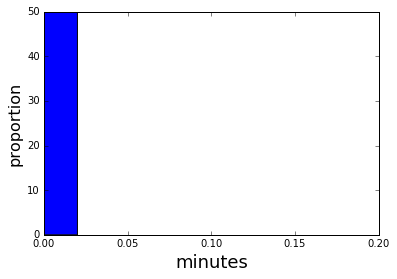

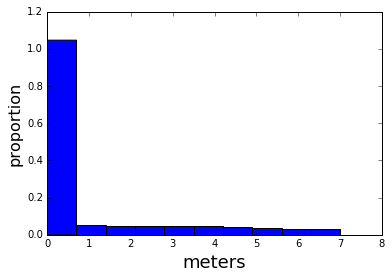

In [5]:
createHistograms([smoothTaxi])

As expected, due to the smoothing algorithm, the distributions are very near a delta function.
### As a measure of "smoothness" one can compute the standard deviation of 
### the distance intervals for a particular taxi

In [6]:
taxi.taxiID

1131

In [7]:
stdOfDeltaD(taxi)

61.613533804337074

In [8]:
stdOfDeltaD(smoothTaxi)

6.2927708766502839

#### The standard deviation for the smooth taxi is about an order of magnitude smaller

### One can visualize the degree of smoothing by plotting the trajectories.

In [9]:
plotRange = [400,500]

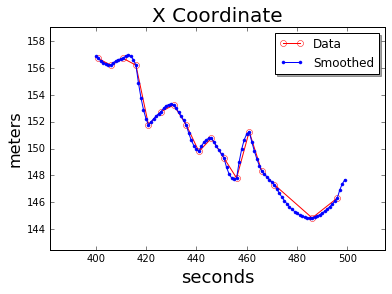

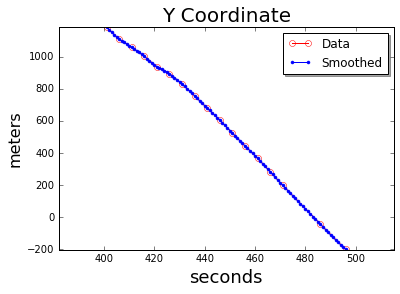

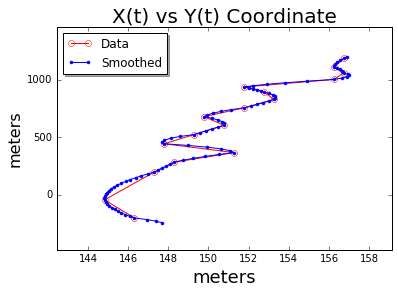

In [10]:
createTrajectoryPlots(taxi,smoothTaxi,plotRange)

### One can qualitatively check the validity of the underlying assumption that 
### the acceleration is a linear function in time by comparing the velocity and 
### acceleration plots between smooth and regular taxis.

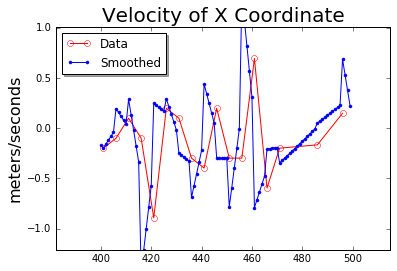

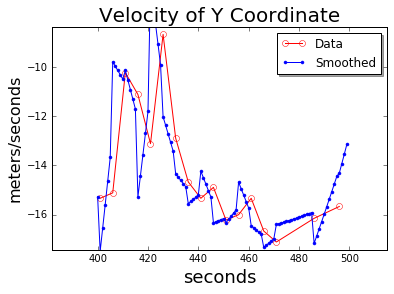

In [11]:
createVelocityPlots(taxi,smoothTaxi,plotRange)

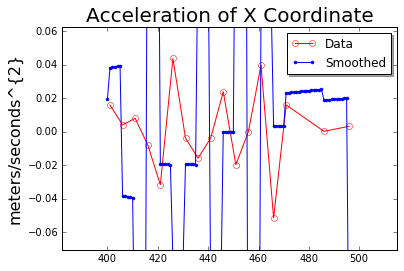

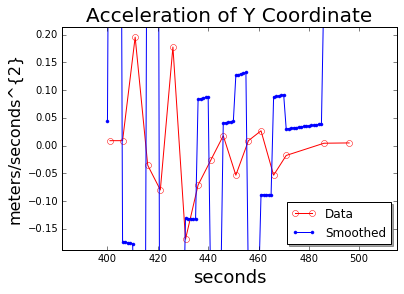

In [12]:
createAccelerationPlots(taxi,smoothTaxi,plotRange)

Qualitatively the velocity appears to fit poorly. The acceleration less so. If one where to fit a linear 

function directly to the acceleration one would obviously get a better fit. But the underlying question is if a

polynomial of degree one truly captures the physics behind how the taxi vehicle is actually accelerating. 

Perhaps one need a higher degree or even a infinite taylor series to capture the acceleration mechanism.

One should also note that the velocity and acceleration values of the taxi where computed numerically not measured

or given directly.

### One can also smooth with the second algorithm.



**Smoothing is with algorithm 2 done in the following manner:**
    
    The fundamental assumptions are:
		1) The data inputed is free of error such that the positions and time 
		intervals are in fact the true values
		2)The acceleration between any two points is linear in t such that
$$ 
\begin{align}
a(t) &= a0 + c\cdot t\\
v(t) &= v0 + a0\cdot t + \frac{c}{2}\cdot t^{2}\\
x(t) &= x0 + v0\cdot t + \frac{a0}{2}\cdot t^2 + \frac{c}{6}\cdot t^3
\end{align}
$$

	To smooth the trajectory we will fit every 2 points. We will solve for the coefficients
	to a cubic function x(t), by solving the 3 sets of equations above using the points as 
	boundary conditions.
	As an example consider points p0 and p1
$$
\begin{align} 
a1 &= a0 + c\cdot t1\\
v1 &= v0 + a0\cdot t1 + \frac{c}{2}\cdot t1^{2}\\
x1 &= x0 + v0\cdot t1 + \frac{a0}{2}\cdot t1^{2} + \frac{c}{6}\cdot t1^{3}
\end{align}
$$

In [13]:
smoothTaxi2 = smoothTrajectory(taxi,desiredDeltaT=1,algorithm="alg2")

In [14]:
taxi.taxiID

1131

In [15]:
stdOfDeltaD(taxi)

61.613533804337074

In [16]:
stdOfDeltaD(smoothTaxi2)

6.1018178172172357

The standards deviation in consecutive distance intervals is about 

the same as that for the taxi object who was smoothed with he first algorihtm.

This would suggest the the second algoritm is just as good


### One can visualize the degree of smoothing by plotting the trajectories.

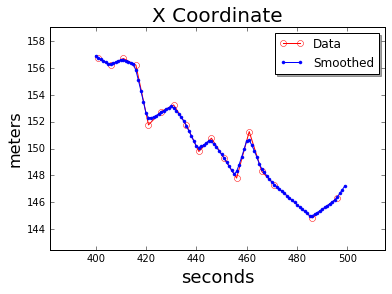

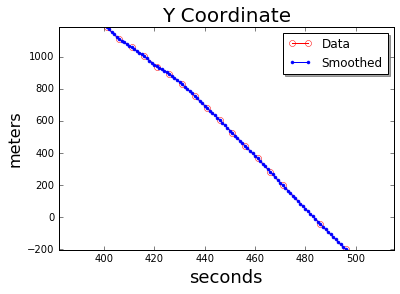

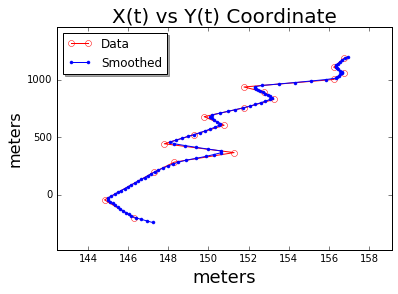

In [17]:
createTrajectoryPlots(taxi,smoothTaxi2,plotRange)

The fit for the smoothTaxi in this case does not exactly pass through the data

points. This is due to that fact that the second fitting algorithm does not 

use the timestamp of the point p0 when computing the coefficients. Thus the value of x0 

is not exactly equal to the value of the fit at t0:
$$(x0_{fit} = fit(t0)) \neq x0$$


###  We can qualitatively  check if the Velocities and acceleration for taxi smoothed with second algorithm are any better

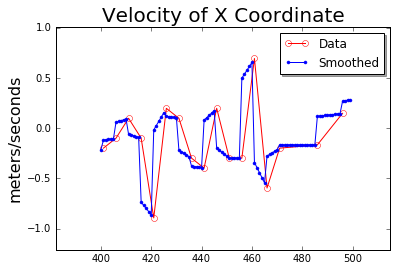

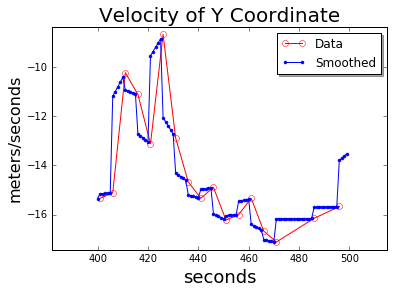

In [18]:
createVelocityPlots(taxi,smoothTaxi2,plotRange)

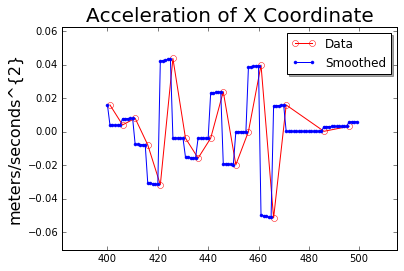

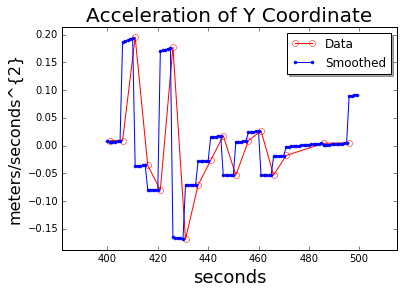

In [19]:
createAccelerationPlots(taxi,smoothTaxi2,plotRange)

Velocity and acceleration fits appear to be slightly better.

### One can, in a ad hoc manner, force the fit to pass through the data points

In [20]:
smoothTaxi2Fit = smoothTrajectory(taxi,desiredDeltaT = 1,algorithm = "alg2", match = "yes" )

In [21]:
stdOfDeltaD(smoothTaxi2Fit)

6.2248553474303998

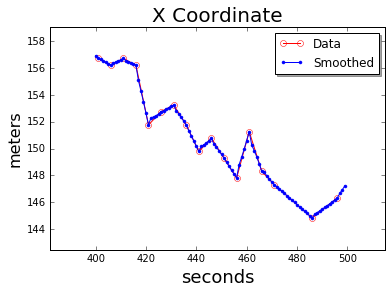

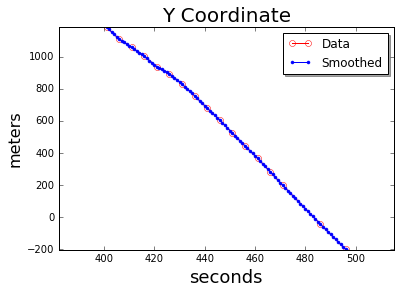

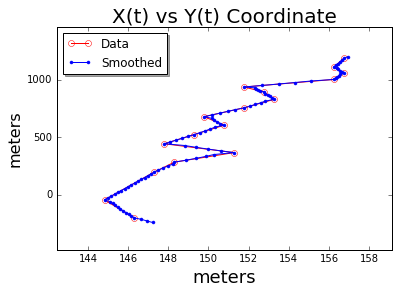

In [22]:
createTrajectoryPlots(taxi,smoothTaxi2Fit,plotRange)

### The result of forcing the fit to pass through the data points seems un-natural.

Both algorithms produce a similar standard deviation for consecutive distance intervals.

Visually the first algorithm looks smoother.

Visually the second algorithm fits the velocity and acceleration slightly better.

Which algorithm is overall better is up to interpretation.

### As fun experiment one can attempt to fit the highest degree polynomial given all the data (ie boundary conditions) we have at our disposal for 2 points. This would be an order 8 polynomial.:
		
	NOTE: For very large values of time the numerical limits of computing for my implementation 
    of this method do not allow for satisfactory fits. The time values could be normalize with 
    respect to the first point, of the two points fitted,
    but from experimentation this results in unexpected numerical oddities 
    when compared to un-normalized time value. My best guess is that the binary
    representation of decimal floats is unexact, so when one preforms additional 
    arithmetic operations on these value they deviate further from the true values. 
    This effect is amplified by the high degree of the polynomial when these altered values 
    are modified by high powers ie ((trueValue + error)^(high power)). One must also take into account
    that depending on the number of bits assigned to numbers the precision of any number
    must be truncated to fit this constraint.
		
	The equations of motion are:
$$
\begin{align}
        a(t) &= a_{0} + b*t  + c*t^{2} + d*t^{3} +e*t^{4} +f*t^{5} g*t^{6}\\
        v(t) &= v_{0} + a_{0}*t + \frac{b}{2}*t^{2} + \frac{c}{3}*t^{3} + \frac{d}{4}*t^{4} +\frac{e}{5}*t^{5} +\frac{f}{6}*t^{6} \frac{g}{7}*t^{7}\\
        x(t) &= x_{0} + v_{0}*t + \frac{a_{0}}{2}*t^{2} + \frac{b}{6}*t^{3} + \frac{c}{12}*t^{4} + \frac{d}{20}*t^{5} +\frac{e}{30}*t^{6} +\frac{f}{42}*t^{7} + \frac{g}{56}*t^{8}
\end{align}
$$

	Consider points p0 and p1:
$$
\begin{align}
		a_{0} - a_{0} &= b*t_{0} + c*t_{0}^{2} + d*t_{0}^{3} +e*t_{0}^{4} +f*t_{0}^{5} g*t_{0}^{6}\\
		v_{0} - v_{0} - a_{0}*t_{0} &= \frac{b}{2}*t_{0}^{2} + \frac{c}{3}*t_{0}^{3} + \frac{d}{4}*t_{0}^{4} +\frac{e}{5}*t_{0}^{5} +\frac{f}{6}*t_{0}^{6} + \frac{g}{7}*t_{0}^{7}\\
		x_{0} - x_{0} - v_{0}*t_{0} - \frac{a_{0}}{2}*t_{0}^{2} &= \frac{b}{6}*t_{0}^{3} + \frac{c}{12}*t_{0}^{4} + \frac{d}{20}*t_{0}^{5} + \frac{e}{30}*t_{0}^{6} + \frac{f}{42}*t_{0}^{7} + \frac{g}{56}*t_{0}^{8}\\
		a_{1} - a_{0} &= b*t_{1} + c*t_{1}^{2} + d*t_{1}^{3} +e*t_{1}^{4} +f*t_{1}^{5} g*t_{1}^{6}\\
		v_{1} - v_{0} - a_{0}*t_{1} &= \frac{b}{2}*t_{1}^{2} + \frac{c}{3}*t_{1}^{3} + \frac{d}{4}*t_{1}^{4} +\frac{e}{5}*t_{1}^{5} +\frac{f}{6}*t_{1}^{6} + \frac{g}{7}*t_{1}^{7}\\
		x_{1} - x_{0} - v_{0}*t_{0} - \frac{a_{0}}{2}*t_{1}^{2} &= \frac{b}{6}*t_{1}^{3} + \frac{c}{12}*t_{1}^{4} + \frac{d}{20}*t_{1}^{5} + \frac{e}{30}*t_{1}^{6} + \frac{f}{42}*t_{1}^{7} + \frac{g}{56}*t_{1}^{8}\\
\end{align}        
$$


In [23]:
subTaxi = Taxi.subTaxi(taxi,[0,1000])

In [24]:
smoothTaxi3 = smoothTrajectory(subTaxi,desiredDeltaT = 1,algorithm = "alg3")

In [25]:
stdOfDeltaD(smoothTaxi3)

13.427214700563836

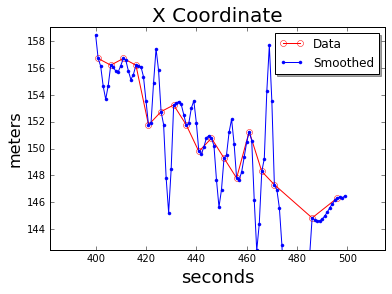

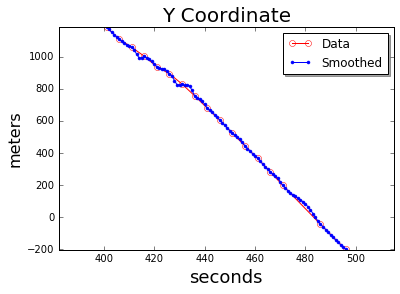

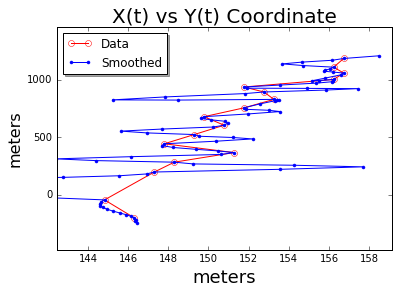

In [26]:
createTrajectoryPlots(taxi,smoothTaxi3,plotRange)

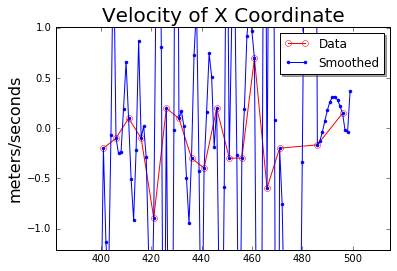

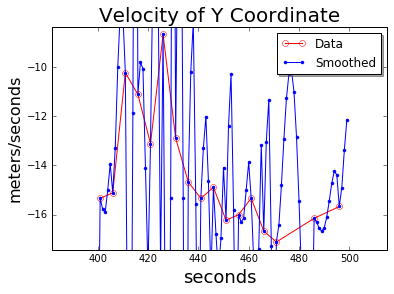

In [27]:
createVelocityPlots(taxi,smoothTaxi3,plotRange)

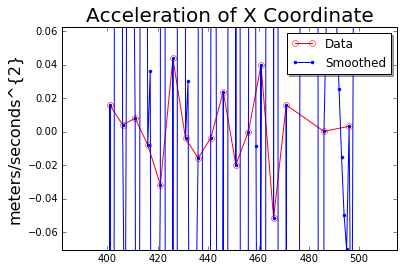

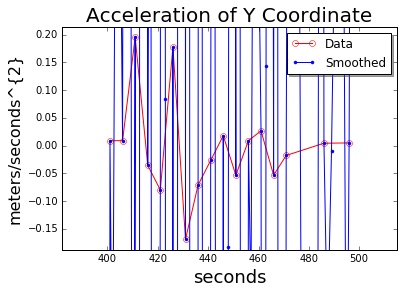

In [28]:
createAccelerationPlots(taxi,smoothTaxi3,plotRange)

### This order 8 fit oscillates wildly and is not a good fit.

Besides its poor fit, my implementation of the fit is limited to small values of t.

### One can can also try a least squares fit to the position, velocity and acceleration between 2 points simultaneously

Algorithm 4 is an attempt to use a least squares parameter optimization
to the position, velocity and acceleration function assuming they take the following 
form:
$$
\begin{align}
a(t) &= a0 + b\cdot t +c\cdot t^{2}\\
v(t) &= v0 + a0\cdot t + \frac{b}{2}\cdot t^{2} + \frac{c}{3}\cdot t^{3}\\
x(t) &= x0 + v0\cdot t + \frac{a0}{2}\cdot t^{2} + \frac{b}{6}\cdot t^{3} + \frac{c}{12}\cdot t^{4}
\end{align}
$$

A quadratic function was chosen for the acceleration in an attempt to capture more features.

This would imply that the square difference equation would take the form:

$$ R2 = \sum{ (X_{i}+V_{i}+A_{i} - [x(t_{i})+v(t_{i})+a(t_{i})] )^2 } $$
	
	Xi, Vi, Ai are the taxi data
	
	Using scipy.optimize.curve_fit whose  inputs are a function to fit "f",
	time intervals to fit over "t" and data to fit to "y"
	
	f = x(ti)+y(ti)+a(ti)
	y = Xi+Vi+Ai


In [29]:
smoothTaxi4 = smoothTrajectory(taxi,desiredDeltaT = 1,algorithm = "alg4")

In [30]:
stdOfDeltaD(smoothTaxi4)

281351.65334009152

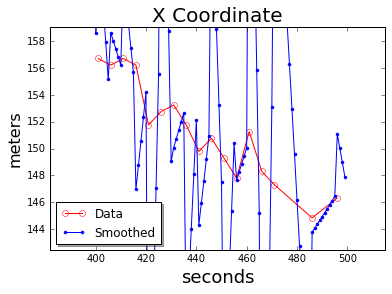

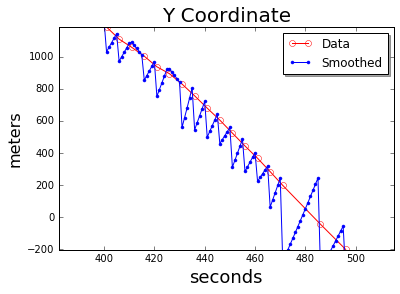

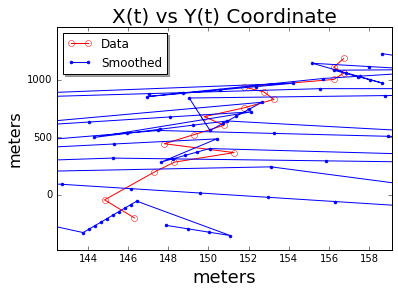

In [31]:
createTrajectoryPlots(taxi,smoothTaxi4,plotRange)

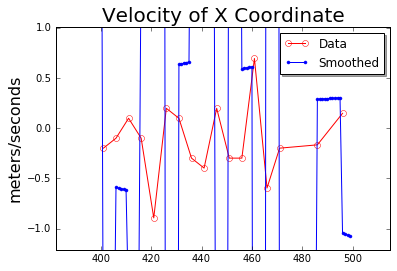

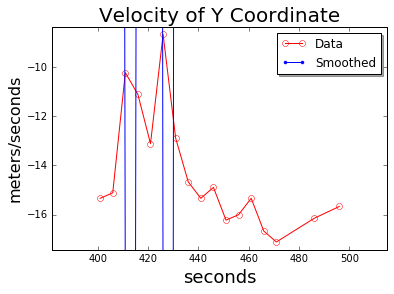

In [32]:
createVelocityPlots(taxi,smoothTaxi4,plotRange)

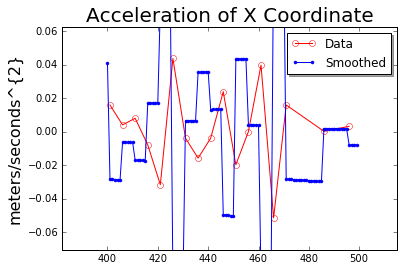

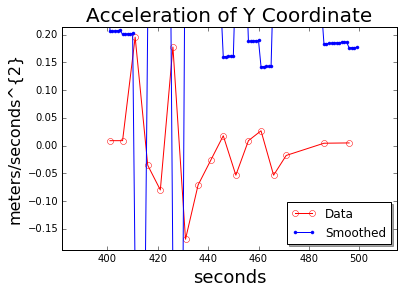

In [33]:
createAccelerationPlots(taxi,smoothTaxi4,plotRange)

### The fits for this final algorithm appear to be worse than the previous ones

## Smoothing Splines

As a final experiment one can fit smooth splines to the taxi data. The scipy.interpolate library has a function that

does just that, UnivariateSpline. Here I fit a order three spline tot he x and y coordinates and let the software

determine the number of knots. I then determine the velocity and acceleration via numerical differentiation. (NOTE:

the software has built in methods that preform differentiation of a given order but I chose not to use it since I

wanted to make sure that the differentiation was numerical and symbolic. By this I mean not simply taking a derivative

of the degree 3 polynomials that where fitted to the data.)

In [48]:
splineTaxi, sx, sy = smoothingSplineTaxi(taxi,desiredDeltaT = 1)

In [49]:
stdOfDeltaD(splineTaxi)

6.2788628179521453

Using the standard deviation as a measure of smoothing. The smoothing splines provide the same order of smoothing as the algorithms displayed above.


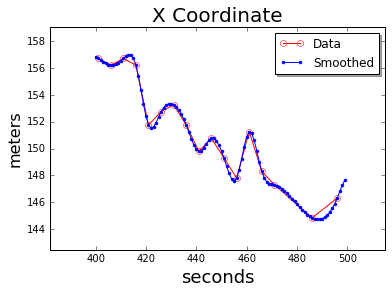

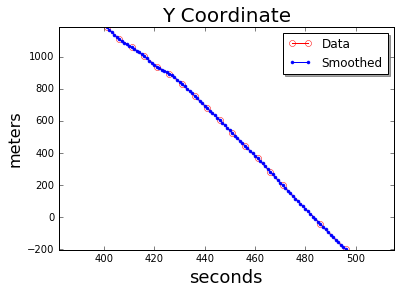

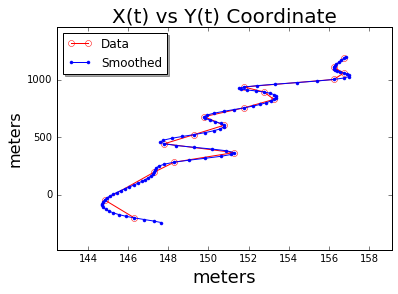

In [51]:
createTrajectoryPlots(taxi,splineTaxi, plotRange)

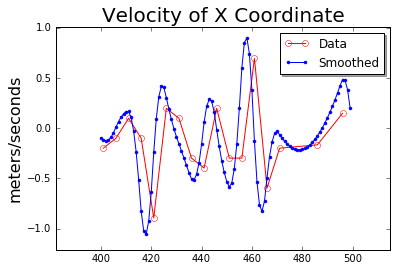

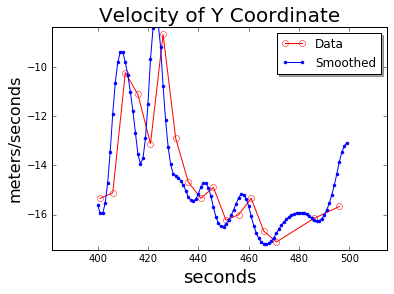

In [52]:
createVelocityPlots(taxi,splineTaxi, plotRange)

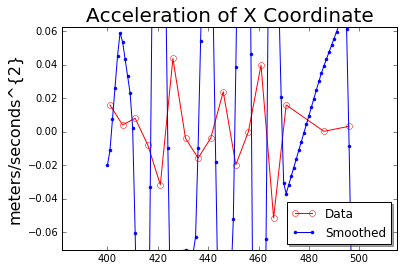

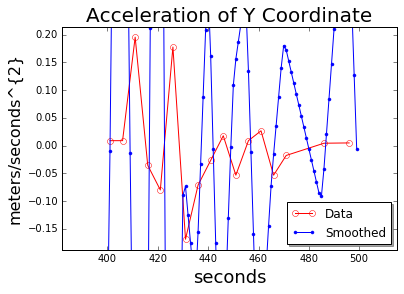

In [63]:
createAccelerationPlots(taxi,splineTaxi, plotRange)

Aesthetically the fits to the position trajectories and velocities are very smooth  and appear continuous in the first and second order derivatives which is expected since it is a condition built into smoothing splines. The acceleration fits appear excessively jagged.


### One can compare the number of knots to the number of data points.

In [62]:
pd.DataFrame({"Number of Data Point":[len(taxi.x)],
              "Number X-Coor Knots":[len(sx.get_knots())], 
              "Number Y-Coor Knots":[len(sy.get_knots())]})

,Number X-Coor Knots,Number Y-Coor Knots,Number of Data Point
0,51825,54220,91090


There is  on the order of 1 knot per set of 2 to 1 data points. The number of knots are selected until the following condition is met

squared error < N where N is the number of points.

$$
\begin{align}
\sqrt{(y_{i}-\hat{f}(x_{i}))^{2}} \leq N
\end{align}
$$

Since we are fitting cubic splines to ever 2 to 1 point it  suggests to me that there is very high variability in the data, forcing the fit to have very high variance and low bias. This is expected since one does not expect taxi trajectories to follow some underlying natural function. 


## Discussion

If forced to choose an algorithm for smoothing I would be inclined to choose algorithm 2 due to the fact the 

degree of smoothing is of the same caliber as algorithm 1 and the fits to the velocity and acceleration are better.

What concerns me about the velocity and acceleration fits is that they appear discontinuous. In an attempt to explain 

this away one can consider the situation where one is driving in a busy area. In such a case one might need to brake 

and accelerate wildly to avoid people and other objects. This could cause a numerical representation of the velocity 

and acceleration to appear discontinuous. 


Visually, the smoothing splines also do a very good job of smoothing out the trajectories and the velocity plots. The

standard deviation of the distance intervals is of the same order as the other algorithms as well. The dominant draw

back to the smoothing spline method is its significantly greater computational cost, which I would imagine is mostly

due to figuring out the optimal places to put the knots given the default smoothing conditions. 

Also, when it comes to my implementation of the velocity and acceleration fits of the smoothing splines method one

must also consider the fact that I took a numerical derivative, while in my implementation for these qualities in the

other algorithms, I used an analytical function as my representation:

$$
\begin{align}
&\text{numerical:} &&v_{i} = \frac{x_{i}-x_{i-1}}{t_{i}-t{i-1}}\\
&		           &&a_{i} = \frac{v_{i}-v_{i-1}}{t_{i}-t{i-1}}\\\\
&\text{analytical:} && v = x’(t)\\
&		            && a = v’(t)\\\\
&\text{analytical example:} &&x = a+bt+ct^{2}+dt^{3}\\
& 		        &&v = b+2ct+3dt^{2}\\
& 	            &&a = 2c+6dt
\end{align}
$$

Thus it may not be completely applicable to compare the results in this regard since the implementation was of a 

different nature.
